In [85]:
import pandas as pd
import spacy

import networkx as nx
from networkx.algorithms import community

import re
import json
import itertools
import langid

import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('..\\data\\ocred\\files_df.csv', index_col = 0)
spacy.prefer_gpu()
nlp = spacy.load("nl_core_news_lg")
nlp_ministries = spacy.load("..\\data\\spacy labeled\\output\\model-last")

c:\Users\justin\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'nl_pipeline' (0.0.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## setup
The co-occurrence network was made with the results of the NER. The network consists of a number of nodes and edges. The nodes, in this case, are the found named entities. If these entities occur in the close together in a text it would count as the nodes sharing an edge. To find the nodes and edges for the network, first a number of random pages are selected. The default is 1000. These pages are then put through the spaCy NER to retreive all named entities. Only entities that were clasified as location, person, and organization were concidered. Then the entities that only occur once or in one document are removed. Some english text exists in the documents so if english texts makes it into the named entities, they are removed. This process results in a python dictionary with document pages as keys and a list of entities that occur in those pages as values. Form this, a list of edges for the network can be generated. The network is also weighted, with the weights being the number of times two nodes co-occured in a page.

## results

One limiting factor is that there is quite some noise from NER. 

In [3]:
def getMatches(doc):

    # list of entities to include
    wantedTypes = ['FAC','GPE','LOC', 'ORG', 'PERSON']
    bannedWords = ['sent', 'cc', 'for', 'te', 'we']

    wantedEnts = []

    # for all entities, check if to include and clean up the string
    for ent in doc.ents:
        if ent.label_ in wantedTypes:
            text = str(ent.text)
            text = text.lower()
            text = re.sub(r'\n', ' ', text)
            text = text.strip()

            if text.endswith('2e'):
                continue
            if text in bannedWords:
                continue
            if len(text) == 1:
                continue
                

            wantedEnts.append(text)    
    
    # retrun list of entities 
    return wantedEnts

In [106]:
# remove all entities that only occur in one document
def goodEnts(entities):
    ents = {}

    # get a dict of entities as keys and a list of documents in which the entity occurs as values
    for document in entities:
        for ent in entities[document]:
            if ent in ents:
                ents[ent].append(document)
            else:
                ents[ent] = [document]

    entsToDelete = []

    # find and deletes entities that only occur in one document
    for ent in ents:
        language = langid.classify(ent)
        if len(ents[ent]) <= 1:
            entsToDelete.append(ent)
        
        # checks if the ent is english
        if language[0] =='en' and language[1] < 0:
            entsToDelete.append(ent)

    for ent in set(entsToDelete):
        del ents[ent]

    documents = {}

    # revert back to original format
    # documents as keys, entities in said document as values
    for ent in ents:
        for doc in ents[ent]:
            if doc in documents:
                documents[doc].append(ent)
            else:
                documents[doc] = [ent]
    
    return documents
    

In [4]:
def getEntities(text, name):
    try:
        text = re.sub('\n+', '\n', text)
        text = re.sub(' +', ' ', text)

        NERdoc = nlp(text)
        NERmatches = getMatches(NERdoc)
        
        # MinDoc = nlp_ministries(text)
        # MinMatches = getMatches(MinDoc)
    except:
        return {name:[]}

    return {name: list(set(NERmatches))}

In [5]:
def orderCheck(x, y):
    ordered = [x, y]
    ordered.sort()
    return ordered[0], ordered[1]

We want a dictionary with named documents as keys and and lists of entities that occur in it as values

In [54]:
def getEdges(n = 1000):
    testDf = df.sample(n, random_state=1)
    entities = testDf.apply(lambda row: getEntities(row['text'], row['full_name']), axis=1)

    entitiesDict = {}

    for d in entities:
        key = list(d.keys())[0]
        entitiesDict[key] = d[key]

    entitiesDict = goodEnts(entitiesDict)

    edges = {}

    for document in entitiesDict:
        if len(entitiesDict[document]) <= 1:
            continue
        
        for edge in itertools.combinations(entitiesDict[document], 2):
            node1, node2 = orderCheck(edge[0], edge[1])
            key = node1 + '\t' + node2 
            if key in edges:
                edges[key].append(document)
            else:
                edges[key] = [document]

    return edges

In [73]:
def makeGraph(n = 100):
    edges = getEdges(n)
    G = nx.Graph()

    for edge in edges:
        nodes = edge.split('\t')
        # G.add_edge(nodes[0], nodes[1])
        G.add_edge(nodes[0], nodes[1], weight = len(edges[edge]))

    x = [len(c) for c in list(nx.connected_components(G))]
    x.sort(reverse=True)
    limit = x[1]
    del x
    for component in list(nx.connected_components(G)):
        if len(component)<=limit:
            for node in component:
                G.remove_node(node)
    print(f'Components: {nx.number_connected_components(G)}\nNumber of edges: {G.number_of_edges()}\nNumber of nodes: {G.number_of_nodes()}')
    return G



# fig = plt.figure(1, figsize=(30, 30), dpi=60)
# nx.draw(G, node_size = 50)

In [74]:
def drawWeightedGraph(G):
    pos = nx.spring_layout(G, seed=0)
    fig = plt.figure(1, figsize=(25, 25), dpi=60)
    nx.draw_networkx(G, pos, with_labels=False, node_size = 50)

    for edge in G.edges(data='weight'):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2], label=None )


Components: 1
Number of edges: 9714
Number of nodes: 895


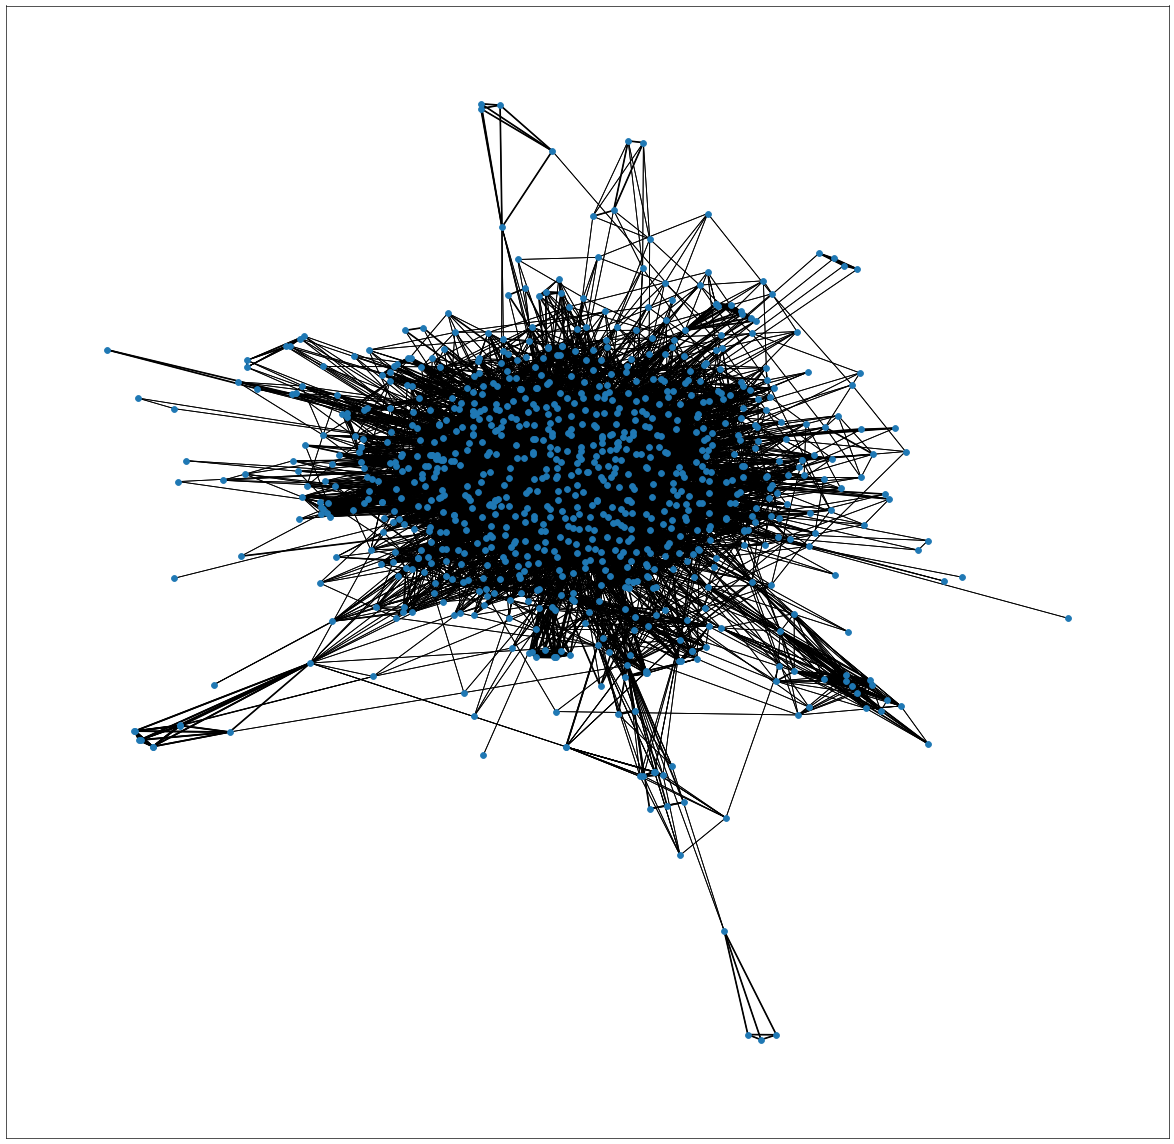

In [107]:
G = makeGraph(1000)
drawWeightedGraph(G)

In [67]:
def communities(G):
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)

    sorted(map(sorted, next_level_communities))


In [110]:
def mostConnectedNodes(G):
    nodeNeighbors = [(node, len(list(G.neighbors(node)))) for node in G.nodes]
    sortedNodes = sorted(nodeNeighbors, key=lambda tup: tup[1])
    return sortedNodes[-20:]

print('Most neighbors')
mostConnectedNodes(G)

Most neighbors


[('am', 98),
 ('sars-cov-2', 99),
 ('duitsland', 99),
 ('wuhan', 100),
 ('den haag', 102),
 ('www.blackberry.com', 104),
 ('ezk', 105),
 ('amsterdam', 109),
 ('tweede kamer', 110),
 ('to', 111),
 ('europa', 120),
 ('ke', 126),
 ('china', 138),
 ('corona', 149),
 ('eu', 180),
 ('pm', 232),
 ('nl', 233),
 ('rivm', 241),
 ('nederland', 361),
 ('covid-19', 378)]

In [111]:
def mostCooccurences(G):

    weightedEdges =  G.edges(data='weight')

    sortedEdges = sorted(weightedEdges, key=lambda tup: tup[2])
    for edge in sortedEdges[-20:]:
        print(edge)

print("edges with highest weight")
mostCooccurences(G)

edges with highest weight
('covid-19', 'sars-cov-2', 11)
('nederland', 'kamer', 11)
('nederland', 'tweede kamer', 11)
('nederland', 'duitsland', 11)
('iao', 'mccb', 11)
('wuhan', 'china', 11)
('covid-19', 'eu', 12)
('nederland', 'frankrijk', 12)
('rivm', 'inf@ct', 12)
('rivm', 'erasmus mc', 12)
('nederland', 'europa', 13)
('www.blackberry.com', 'pm', 13)
('eu', 'nl', 14)
('pm', 'to', 14)
('nederland', 'eu', 15)
('nederland', 'nl', 15)
('rivm', 'pm', 18)
('nederland', 'rivm', 20)
('covid-19', 'rivm', 25)
('covid-19', 'nederland', 33)


In [116]:
def calculateCentrality(G):
    centrality = nx.degree_centrality(G)
    centrality = [(x, centrality[x]) for x in centrality]
    centrality = sorted(centrality, key=lambda tup: tup[1])
    print('centrality of nodes')
    for node in centrality[-20:]:
        print(node)
calculateCentrality(G)

('am', 0.10961968680089486)
('sars-cov-2', 0.11073825503355704)
('duitsland', 0.11073825503355704)
('wuhan', 0.11185682326621924)
('den haag', 0.11409395973154363)
('www.blackberry.com', 0.116331096196868)
('ezk', 0.1174496644295302)
('amsterdam', 0.12192393736017897)
('tweede kamer', 0.12304250559284116)
('to', 0.12416107382550336)
('europa', 0.1342281879194631)
('ke', 0.14093959731543623)
('china', 0.15436241610738255)
('corona', 0.16666666666666666)
('eu', 0.20134228187919462)
('pm', 0.2595078299776286)
('nl', 0.2606263982102908)
('rivm', 0.2695749440715884)
('nederland', 0.40380313199105144)
('covid-19', 0.4228187919463087)


In [119]:
def calculateBetweenness(G):
    betweenness = nx.betweenness_centrality(G)
    betweenness = [(x, betweenness[x]) for x in betweenness]
    betweenness = sorted(betweenness, key=lambda tup: tup[1])
    print('betweenness of nodes')
    for node in betweenness[-20:]:
        print(node)

calculateBetweenness(G)

betweenness of nodes
('am', 0.012665212391284908)
('tk', 0.012685251837928903)
('www.blackberry.com', 0.01486305790406969)
('tozo', 0.016176604466704127)
('den haag', 0.01620842286317573)
('to', 0.01668474832544074)
('tweede kamer', 0.018734622800439714)
('china', 0.02283581925632336)
('amsterdam', 0.02408125303079314)
('europa', 0.026950464891629992)
('cbs', 0.02717414254719608)
('ke', 0.027294949619847558)
('ezk', 0.03121215925371423)
('corona', 0.038225572586183795)
('eu', 0.038831023866966255)
('pm', 0.06667468101658998)
('rivm', 0.07062944798285443)
('nl', 0.09000005887208198)
('covid-19', 0.1932496896337486)
('nederland', 0.19648670355150308)


In [121]:
def calculateCloseness(G):
    closeness = nx.closeness_centrality(G)
    closeness = [(x, closeness[x]) for x in closeness]
    closeness = sorted(closeness, key=lambda tup: tup[1])
    print('closeness of nodes')
    for node in closeness[-20:]:
        print(node)
calculateCloseness(G)

closeness of nodes
('iao', 0.498050139275766)
('frankrijk', 0.4986056887897379)
('bz', 0.49888392857142855)
('www.blackberry.com', 0.49888392857142855)
('duitsland', 0.49972051425377306)
('to', 0.49972051425377306)
('tweede kamer', 0.5005599104143337)
('wuhan', 0.5068027210884354)
('amsterdam', 0.5068027210884354)
('ke', 0.5085324232081911)
('ezk', 0.5105653912050258)
('europa', 0.5137931034482759)
('china', 0.5194654270772806)
('corona', 0.5252643948296122)
('eu', 0.5308788598574822)
('pm', 0.5481299816063765)
('nl', 0.5539033457249071)
('rivm', 0.557356608478803)
('nederland', 0.6148555708390646)
('covid-19', 0.6169772256728778)
